In [44]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision
from torchvision.transforms import v2 as transforms
from torchvision.models.feature_extraction import create_feature_extractor
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import MDS
import pandas as pd

import train

# Why SimCLR?

Fully supervised Models
* The more typical method to train models for cognitive neuroscience are fully supervised models. 
* Every image of a datset has a label and the model is trained to categorize every image.
* This creates a model that can generate useful representations for even unseen images and categories.

Unsupervised Models
* We may not have labels for all images in a dataset.
* A fully-supervised model may not make sense to model the human brain.
* The label may not be the most important part of the image.

# Demo simCLR transforms

For a given batch of N images, each image will be augmented twice, resulting in
2N images to calculate loss. Each image will have random crop and scale,
horizontal flip, color distortion, and Gaussian blur applied.


Files already downloaded and verified


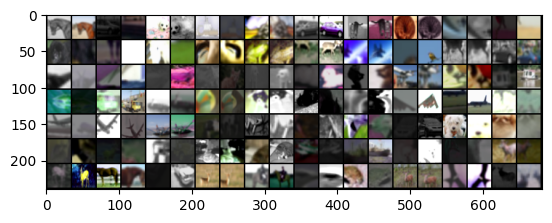

In [34]:
# This transform returns 2 copies of every image
transform = train.simCLR_transform()

cifarTest = train.CIFAR10_Paired(
    root="./data", train=False, download=True, transform=transform
)
testLoader = DataLoader(cifarTest, batch_size=70, shuffle=True)

# Get a batch (and reshape to handle double images)
images, labels = next(iter(testLoader))
shape = images.shape
images = images.view(shape[0] * 2, shape[2], shape[3], shape[4])

# Display grid
grid = torchvision.utils.make_grid(images, nrow=20)
grid = np.transpose(grid, (1, 2, 0))

_ = plt.imshow(grid)

The types of augmentations and intensity matters. It can either be thought of
either as ways to avoid the model from "cheating" to take shortcuts on what
makes the image the same or as different invariances we want the model to be
trained be good on.

Scaling and cropping + color distortion are the most important.

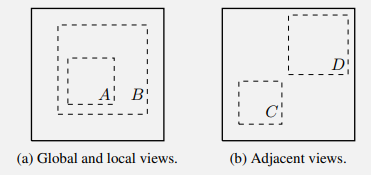

Scaling and cropping grants important invariances as seen above. Color
distortion prevents the model from just using color as a shortcut.


# Training SimCLR

The general strategy is to ask the model to maximize similarity between the
same images augmentated in different ways (positive pairs) and minimize the
similarity between different images (negative pairs).

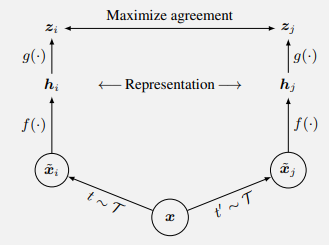

The loss function instantiates this very simply.

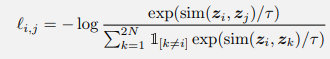

Basically, for a batch of images (where each image is augmented twice), we
calculate the similarity between all pairs of images. We take the
similarity of each positive pair and divide it by the sum of the similarities
of the negative pairs. More precisely, we use cosine similarity (though other
similarity measures could be used) scaled to some temperature constant with cross
entropy for the actual loss function.

The rest of the code in `train.py` is a simple instantiation of the SimCLR
framework (alongside an commensurate feedforward fully supervised model). We
implemented it with barebones models that may not be the best for the task and
somewhat inefficient implementation of the loss function/augmentations. The
models were trained on an old GPU (RTX 970), which takes a few hours to finish
training the SimCLR (the simple supervised model is much faster). However,
these implementations should be relatively accessible and easy to understand.

The default parameters for training are the ones used to train the model 
demonstrated below. The hyperparameters can be pretty important with a lot of 
room for improvements. Many combinations of hyperparameters simply result in a
model that is very inefficient and take forever to train (much more than the
100 epochs). Low temperature with low learning rate appears to be important for 
our architecture. Higher batch sizes also improve the model (but require 
greater computational resources to pull off).

We trained a very basic model using the SimCLR framework over 100 epochs.
Training is somewhat slow but the loss stably decreases over epochs.


Text(0, 0.5, 'NT-Xent Loss')

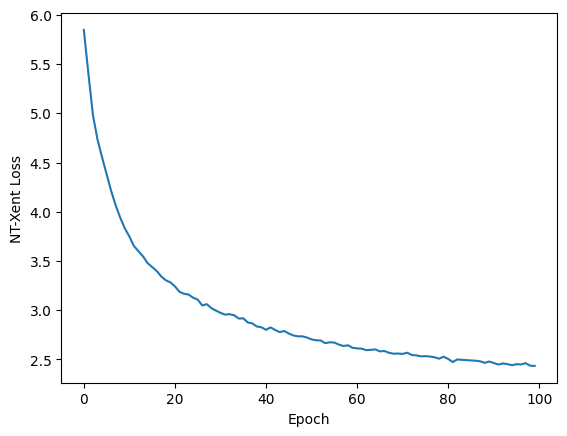

In [50]:
# Load training log
simClrLog = pd.read_csv("unsupervisedTrainingLog.csv")

# Plot loss
plt.plot(simClrLog["Train_Loss"])

# Label axes
plt.xlabel("Epoch")
plt.ylabel("NT-Xent Loss")

# Representational Space

We can use the trained model to generate a similarity matrix across a set of
images and apply MDS to take a look at the representational space.


In [35]:
# Load CNN
model = train.cnn_simCLR()
model.load_state_dict(torch.load("unsupervised.pth"))
model.eval()

# Get the normal test set of CIFAR10
cifarTest = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
testLoader = DataLoader(cifarTest, batch_size=156, shuffle=True)

# Get the embeddings from some images
targetImages = 1000
imgCount = 0
embeddings = []
cats = []
for images, labels in testLoader:
    with torch.no_grad():
        embeddings.append(model(images))
    cats.append(labels)

    imgCount += len(labels)
    if imgCount >= targetImages:
        break

embeddings = torch.cat(embeddings)
cats = torch.cat(cats)

/data/venv/research/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Files already downloaded and verified


Text(0.5, 1.0, 'MDS of CIFAR10 embeddings from SimCLR')

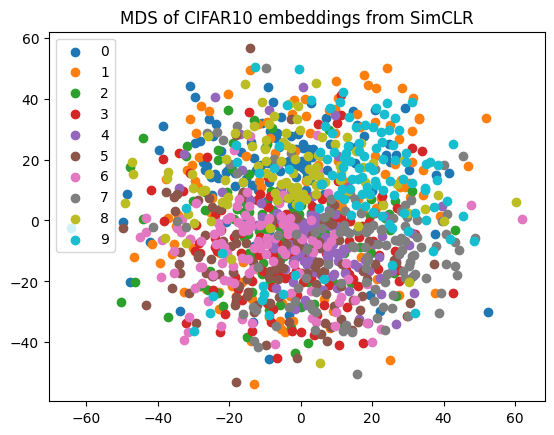

In [36]:
# Do MDS on embeddings
mds = MDS(n_components=2)
mdsEmbeddings = mds.fit_transform(embeddings)

# Plot the embeddings
plt.figure()
for i in range(10):
    mask = cats == i
    plt.scatter(mdsEmbeddings[mask, 0], mdsEmbeddings[mask, 1], label=str(i))
plt.legend()
plt.title("MDS of CIFAR10 embeddings from SimCLR")

# SimCLR classifier

We can also use a trained SimCLR model to train on a new downstream task. Below
we demonstrate how we can use it to create a classifier for the CIFAR-10 dataset.


In [37]:
# Modify the model to be a linear classifier
class simClr_classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = train.cnn_simCLR()
        self.encoder.load_state_dict(torch.load("unsupervised.pth"))

        for param in self.encoder.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

In [38]:
# Setup model
model = simClr_classifier()
model = model.cuda()
print(summary(model, (1, 3, 32, 32)))

# Setup data
transform = transforms.Compose(
    [transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]
)
cifarTrain = CIFAR10(root="./data", train=True, download=True, transform=transform)
cifarTest = CIFAR10(root="./data", train=False, download=True, transform=transform)

trainLoader = DataLoader(cifarTrain, batch_size=128, shuffle=True)
testLoader = DataLoader(cifarTest, batch_size=128, shuffle=False)

/data/venv/research/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Output Shape              Param #
simClr_classifier                        [1, 10]                   --
├─cnn_simCLR: 1-1                        [1, 128]                  --
│    └─cnn: 2-1                          [1, 192, 8, 8]            --
│    │    └─Sequential: 3-1              [1, 96, 16, 16]           (85,728)
│    │    └─Sequential: 3-2              [1, 192, 8, 8]            (498,048)
│    └─Sequential: 2-2                   [1, 128]                  --
│    │    └─Flatten: 3-3                 [1, 12288]                --
│    │    └─Linear: 3-4                  [1, 128]                  (1,572,992)
│    │    └─ReLU: 3-5                    [1, 128]                  --
│    │    └─Linear: 3-6                  [1, 128]                  (16,512)
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-3                       [1, 128]                  16,512
│    └─ReLU: 2-4                         [1, 128]    

In [39]:
# Training functions
lossFun = nn.CrossEntropyLoss()
sgd = optim.SGD(
    model.parameters(),
    lr=0.01,
    weight_decay=1e-6,
)

# Training loop
for epoch in range(40):
    trainLosses = []
    trainAccs = []

    model.train()
    for images, labels in trainLoader:
        images = images.cuda()
        labels = labels.cuda()

        # Zero out gradients
        sgd.zero_grad()

        # Get outputs
        output = model(images)

        # Calculate loss
        loss = lossFun(output, labels)

        # Record metrics
        trainLosses += [loss.item()]
        trainAccs += [(output.argmax(1) == labels).sum().item() / len(labels)]

        # Update weights
        loss.backward()
        sgd.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        testLoss = 0.0
        testAcc = 0.0

        for images, labels in testLoader:
            images = images.cuda()
            labels = labels.cuda()

            output = model(images)
            loss = lossFun(output, labels)

            testLoss += loss.item()
            testAcc += (output.argmax(1) == labels).sum().item()

        testLoss /= len(testLoader)
        testAcc /= len(cifarTest)

    print(
        f"Epoch {epoch + 1}: Train Loss: {np.mean(trainLosses):5.3f}, Train Accuracy: {np.mean(trainAccs):5.3f}, Test Loss: {testLoss:5.3f}, Test Accuracy: {testAcc:5.3f}"
    )

Epoch 1: Train Loss: 1.655, Train Accuracy: 0.462, Test Loss: 1.176, Test Accuracy: 0.603
Epoch 2: Train Loss: 1.111, Train Accuracy: 0.614, Test Loss: 1.022, Test Accuracy: 0.640
Epoch 3: Train Loss: 1.039, Train Accuracy: 0.637, Test Loss: 0.975, Test Accuracy: 0.659
Epoch 4: Train Loss: 1.006, Train Accuracy: 0.648, Test Loss: 0.953, Test Accuracy: 0.665
Epoch 5: Train Loss: 0.987, Train Accuracy: 0.655, Test Loss: 0.933, Test Accuracy: 0.671
Epoch 6: Train Loss: 0.967, Train Accuracy: 0.664, Test Loss: 0.918, Test Accuracy: 0.680
Epoch 7: Train Loss: 0.953, Train Accuracy: 0.666, Test Loss: 0.912, Test Accuracy: 0.682
Epoch 8: Train Loss: 0.939, Train Accuracy: 0.672, Test Loss: 0.897, Test Accuracy: 0.685
Epoch 9: Train Loss: 0.927, Train Accuracy: 0.676, Test Loss: 0.884, Test Accuracy: 0.692
Epoch 10: Train Loss: 0.919, Train Accuracy: 0.678, Test Loss: 0.873, Test Accuracy: 0.697
Epoch 11: Train Loss: 0.907, Train Accuracy: 0.682, Test Loss: 0.869, Test Accuracy: 0.697
Epoch 12

# Fully Supervised Example

We can compare the representational space and test accuracy of the SimCLR model
with a fully-supervised model.


In [40]:
model = train.cnn()
model.load_state_dict(torch.load("supervised.pth"))
model

cnn(
  (block1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(192, 10, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (5): AdaptiveAvgPool2d(output_size=(1, 1))
    (6): Flatten(start_dim=1, end_dim=-1)
  )
)

In [41]:
# Load CNN
model = train.cnn()
model.load_state_dict(torch.load("supervised.pth"))
model = create_feature_extractor(model, ["classifier.3"])
model.eval()

# Get the normal test set of CIFAR10
cifarTest = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
testLoader = DataLoader(cifarTest, batch_size=156, shuffle=True)

# Get the embeddings from some images
targetImages = 1000
imgCount = 0
embeddings = []
cats = []
for images, labels in testLoader:
    with torch.no_grad():
        embeddings.append(model(images)["classifier.3"])
    cats.append(labels)

    imgCount += len(labels)
    if imgCount >= targetImages:
        break

embeddings = torch.cat(embeddings)
cats = torch.cat(cats)

# Apply global average pooling
embeddings = nn.functional.adaptive_avg_pool2d(embeddings, (1, 1)).squeeze()

Files already downloaded and verified


Text(0.5, 1.0, 'MDS of CIFAR10 embeddings from Fully Supervised')

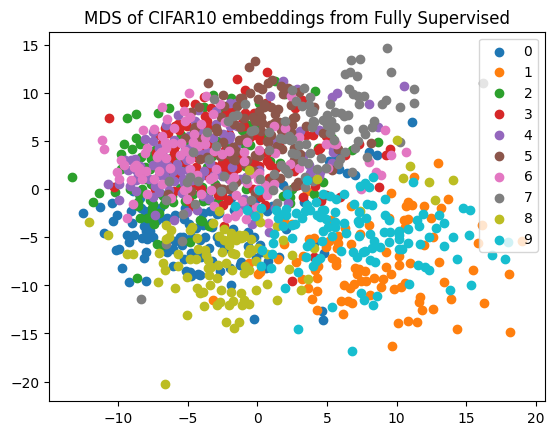

In [43]:
# Do MDS on embeddings
mds = MDS(n_components=2)
mdsEmbeddings = mds.fit_transform(embeddings)

# Plot the embeddings
plt.figure()
for i in range(10):
    mask = cats == i
    plt.scatter(mdsEmbeddings[mask, 0], mdsEmbeddings[mask, 1], label=str(i))
plt.legend()
plt.title("MDS of CIFAR10 embeddings from Fully Supervised")

Text(0, 0.5, 'Cross Entropy Loss')

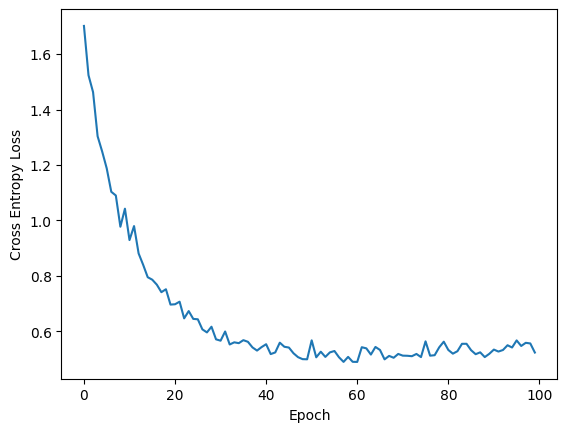

In [52]:
# Load supervised training log
supervisedLog = pd.read_csv("supervisedTrainingLog.csv")

# Plot loss
plt.plot(supervisedLog["Test_Loss"])

# Label axes
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")

Text(0, 0.5, 'Test Accuracy')

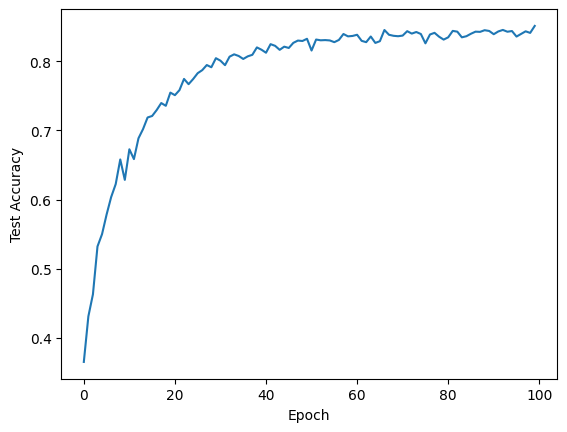

In [54]:
# Also plot test accuracy
plt.plot(supervisedLog["Test_Accuracy"])

# Label axes
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")